In [3]:
import helpers
# import optical_flow

import numpy as np
import cv2
import scipy.signal
from PIL import Image
from skimage import transform as tf
import matplotlib.pyplot as plt
from helpers import *

In [15]:
import numpy as np
import cv2
import scipy.signal
from PIL import Image
from skimage import transform as tf

from helpers import *


def getFeatures(img,bbox):
    """
    Description: Identify feature points within bounding box for each object
    Input:
        img: Grayscale input image, (H, W)
        bbox: Top-left and bottom-right corners of all bounding boxes, (F, 2, 2)
    Output:
        features: Coordinates of all feature points in first frame, (F, N, 2)
    Instruction: Please feel free to use cv2.goodFeaturesToTrack() or cv.cornerHarris()
    """
    num_boxes = bbox.shape[0] # number of bounding boxes
    num_corners = 10 # number of points to track
    quality_level = 0.1
    dist_threshold = 5

    curr = []
    curr_features = []
    for b in range(num_boxes):
        # Get the rectangle dimensions
        tl_x = int(bbox[b][0][0])
        tl_y = int(bbox[b][0][1])
        br_x = int(bbox[b][1][0])
        br_y = int(bbox[b][1][1])

        # Get the cropped image
        cropped_img = img[tl_y:br_y,tl_x:br_x]

        # Validation
        # print("Rectangle coords", tl_x, tl_y, br_x, br_y)
        # print("Image Dims: ", img.shape)
        # print("Cropped Image Dims: ", cropped_img.shape)

        # Get the features
        points = cv2.goodFeaturesToTrack(cropped_img, num_corners, quality_level, dist_threshold)

        # Get the list of x,y coords
        for i in points:
            x, y = i.ravel()
            x = x + tl_x
            y = y + tl_y
            curr.append([x, y])
            # print(x,y)

        # Add the current bounding box's features to the final list
        curr_features.append(np.stack(curr))

    # Stack all the features
    features = np.stack(curr_features)

    # Validation
    # print("Shape of features:", features.shape)

    # Return the features
    return features


def estimateFeatureTranslation(feature, Ix, Iy, img1, img2):
    """
    Description: Get corresponding point for one feature point
    Input:
        feature: Coordinate of feature point in first frame, (2,)
        Ix: Gradient along the x direction, (H,W)
        Iy: Gradient along the y direction, (H,W)
        img1: First image frame, (H,W,3)
        img2: Second image frame, (H,W,3)
    Output:
        new_feature: Coordinate of feature point in second frame, (2,)
    Instruction: Please feel free to use interp2() and getWinBound() from helpers
    """

    img1_p = img1
    img2_p = img2
    dx_sum = 0
    dy_sum = 0
    # for i in range(20): #TBD: Only 1 iteration according to the Piazza post
    # Compute the difference between 2 images
    # print(type(feature))
    # print(feature)
    # img1_q = []
    # img2_q = []
    # for f in feature:
    #     img1_q.append(img1_p[int(f[1])][int(f[0])])
    #     img2_q.append(img2_p[int(f[1])][int(f[0])])
    #
    # img1_p = np.stack(img1_q)
    # img2_p = np.stack(img2_q)

    It = img2_p - img1_p

    # Compute the 2D matrix
    A = np.hstack((Ix.reshape(-1, 1), Iy.reshape(-1, 1)))
    b = -It.reshape(-1,1)

    # Solve the linear equation
    res = np.linalg.solve(A.T @ A, A.T @ b)
    dx = res[0,0]
    dy = res[1,0]

    # Total translation
    dx_sum += dx
    dy_sum += dy

    # if(dx_sum < 0):
    #     dx_sum = dx_sum * -1
    # if (dy_sum < 0):
    #     dy_sum = dy_sum * -1

    print(dx_sum, dy_sum)

    # Get the new image
    x, y = np.meshgrid(np.arange(img2_p.shape[1]), np.arange(img2_p.shape[0]))
    new_x, new_y = x + dx_sum, y + dy_sum
    new_feature = feature + [dx_sum, dy_sum]
    img1_p = img2_p
    img2_p = interp2(img2_p, new_x, new_y)


    #Validation
    # print(new_feature.shape)
    # print(feature, new_feature)

    return new_feature


def estimateAllTranslation(features, img1, img2):
    """
    Description: Get corresponding points for all feature points
    Input:
        features: Coordinates of all feature points in first frame, (F, N, 2)
        img1: First image frame, (H,W,3)
        img2: Second image frame, (H,W,3)
    Output:
        new_features: Coordinates of all feature points in second frame, (F, N, 2)
    """
    print("***Estimating all translations***")
    # Init
    curr_features = []

    # Find gradient
    ksize = 10
    sigma = 1
    G = cv2.getGaussianKernel(ksize, sigma)
    G = G @ G.T
    fx = np.array([[1, -1]])
    fy = fx.T
    Gx = scipy.signal.convolve2d(G, fx, 'same', 'symm')[:, 1:]
    Gy = scipy.signal.convolve2d(G, fy, 'same', 'symm')[1:, :]
    Ix = scipy.signal.convolve2d(img2, Gx, 'same', 'symm')
    Iy = scipy.signal.convolve2d(img2, Gy, 'same', 'symm')

    # Validation
    # print("img1", img1.shape)
    # print("img2", img2.shape)
    # print("Ix", Ix.shape)
    # print("Iy", Iy.shape)

    # Traverse for every feature
    # print("Curr Features: ", features.shape)
    for f in features:
        new_f = estimateFeatureTranslation(f, Ix, Iy, img1, img2)
        curr_features.append(new_f)
    new_features = np.stack(curr_features)

    # Validation
    # print("New features: ", new_features.shape)
    return new_features


def applyGeometricTransformation(features, new_features, bbox):
    """
    Description: Transform bounding box corners onto new image frame
    Input:
        features: Coordinates of all feature points in first frame, (F, N, 2)
        new_features: Coordinates of all feature points in second frame, (F, N, 2)
        bbox: Top-left and bottom-right corners of all bounding boxes, (F, 2, 2)
    Output:
        features: Coordinates of all feature points in first frame after eliminating outliers, (F, N1, 2)
        bbox: Top-left and bottom-right corners of all bounding boxes, (F, 2, 2)
    Instruction: Please feel free to use skimage.transform.estimate_transform()
    """

    # Calculate the H matrix using features and new_features (similarity transform?)
    # print(features.shape)
    # print(new_features.shape) TBD: done for 1 feature only
    # transform_matrices = []
    # for i in range(len(features)):
    #     transform_matrices.append(tf.estimate_transform('similarity', features[i], new_features[i]))
    # transform_matrices = np.stack(transform_matrices)
    # transform_matrix = np.average(transform_matrices, axis=0)
    # index = int(np.random.rand((len(features))))
    # transform_matrix = tf.estimate_transform('similarity', features[index], new_features[index])

    # # Use the symmetric transformation to find where the new bounding box will be
    # # print(bbox.shape)
    # new_bbox = []
    # for b in bbox:
    #     new_b = transform_matrix(b)
    #     new_bbox.append(new_b)
    # new_bbox = np.stack(new_bbox)

    new_bbox = []
    for i in range(len(features)):
        transform_matrix = tf.estimate_transform('similarity', features[i], new_features[i])
        new_b = transform_matrix(bbox[i])
        new_bbox.append(new_b)
    new_bbox = np.stack(new_bbox)

    # Filter invalid feature points
    # Eliminate the features that move too much
    curr_features = []
    for i in range(features.shape[0]):
        f1 = features[i]
        f2 = new_features[i]
        diff = f1 - f2
        # print(diff.shape)
        val = np.sum(diff[0]**2 + diff[1]**2)
        if val < 6:
            curr_features.append(f2)
    new_features = np.stack(curr_features)

    # Eliminate the features outside bbox
    curr_features = []
    for f in new_features:
        keep = True
        for c in f:
            for b in new_bbox:
                tl_x = int(b[0][0])
                tl_y = int(b[0][1])
                br_x = int(b[1][0])
                br_y = int(b[1][1])
                if not (tl_x <= c[0] <= br_x and tl_y <= c[1] <= br_y):
                    keep = False
                    break
        if keep:
            curr_features.append(f)
    new_features = np.stack(curr_features)


    return new_features, new_bbox





In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
from skimage import img_as_ubyte
import os

from optical_flow import *

def objectTracking(rawVideo):
    """
    Description: Generate and save tracking video
    Input:
        rawVideo: Raw video file name, String
    Instruction: Please feel free to use cv.selectROI() to manually select bounding box
    """
    cap = cv2.VideoCapture(rawVideo)
    imgs = []
    frame_cnt = 0 

    # Initialize video writer for tracking video
    trackVideo = 'results/Output_' + rawVideo
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    fps = cap.get(cv2.CAP_PROP_FPS)
    size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)), int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    writer = cv2.VideoWriter(trackVideo, fourcc, fps, size)
    
    # Define how many objects to track
    F = 1
                  
    while (cap.isOpened()):
        ret, frame = cap.read()
        if not ret: continue
        vis = frame.copy()
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255
        frame_cnt += 1

        print(frame_cnt)
        if frame_cnt == 1:
            bbox = np.zeros((F,2,2))
            
            # Manually select objects on the first frame
            for f in range(F):
                x,y,w,h = np.int32(cv2.selectROI("roi", vis, fromCenter=False))
                cv2.destroyAllWindows()
                bbox[f] = np.array([(x,y), (x+w, y+h)])
                
            features = getFeatures(frame, bbox)
            # print("First set of features gotten", features.shape)
            frame_old = frame.copy()

        else:
            # print("Sending features out", features.shape)
            features = getFeatures(frame, bbox)
            new_features = estimateAllTranslation(features, frame_old, frame)
            features, bbox = applyGeometricTransformation(features, new_features, bbox)
            frame_old = frame.copy()
            
        # # display the bbox
        for f in range(F):
            cv2.rectangle(vis, tuple(bbox[f,0].astype(np.int32)), tuple(bbox[f,1].astype(np.int32)), (0,0,255), thickness=2)
        
        # display feature points
        for f in range(F):
            for feature in features[f]:
                cv2.circle(vis, tuple(feature.astype(np.int32)), 2, (0,255,0), thickness=-1)
        
        # save to list
        imgs.append(img_as_ubyte(vis))
        
        # save image
        if (frame_cnt + 1) % 10 == 0:
            cv2.imwrite('results/{}.jpg'.format(frame_cnt), img_as_ubyte(vis))

        # Save video with bbox and all feature points
        writer.write(vis)
        
        # Press 'q' on the keyboard to exit
        cv2.imshow('Track Video', vis)
        if cv2.waitKey(30) & 0xff == ord('q'): break
        
        
    # Release video reader and video writer
    cv2.destroyAllWindows()
    cap.release()
    writer.release()
    
    return

In [ ]:
rawVideo = "Easy.mp4"
if not os.path.exists("results"): os.mkdir("results")
objectTracking(rawVideo)

## Feature detection in single frame

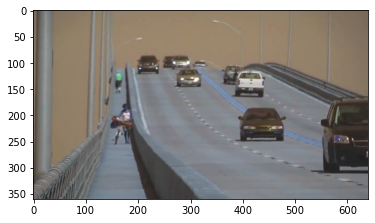

In [46]:
frame1= cv2.imread("./results/859.jpg")
frame2 = cv2.imread("./results/869.jpg")
plt.imshow(frame1)

In [6]:
bbox = np.zeros((1,2,2))
x,y,w,h = np.int32(cv2.selectROI("roi", frame1, fromCenter=False))
cv2.destroyAllWindows()
bbox[0] = np.array([(x,y), (x+w, y+h)])

In [7]:
bbox

array([[[193., 122.],
        [309., 233.]]])

In [45]:
# Define how many objects to track
F = 1
f=0
frame_cnt = 0 
frame = frame1
vis = frame.copy()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY).astype(np.float32) / 255
frame_cnt += 1

print(frame_cnt)
if frame_cnt == 1:
    bbox = np.zeros((F,2,2))

    # Manually select objects on the first frame
    for f in range(F):
        x,y,w,h = np.int32(cv2.selectROI("roi", vis, fromCenter=False))
        cv2.destroyAllWindows()
        bbox[f] = np.array([(x,y), (x+w, y+h)])

    features = getFeatures(frame, bbox)
    # print("First set of features gotten", features.shape)
    frame_old = frame.copy()

else:
    # print("Sending features out", features.shape)
    features = getFeatures(frame, bbox)
    new_features = estimateAllTranslation(features, frame_old, frame)
    features, bbox = applyGeometricTransformation(features, new_features, bbox)
    frame_old = frame.copy()

# # display the bbox
for f in range(F):
    print("l33")
    cv2.rectangle(vis, tuple(bbox[f,0].astype(np.int32)), tuple(bbox[f,1].astype(np.int32)), (0,0,255), thickness=2)

# display feature points
for f in range(F):
    for feature in features[f]:
        cv2.circle(vis, tuple(feature.astype(np.int32)), 2, (0,255,0), thickness=-1)
        
        
# Press 'q' on the keyboard to exit
cv2.imshow('Track Video', vis)
# if cv2.waitKey(30) & 0xff == ord('q'): break        

# Release video reader and video writer
cv2.destroyAllWindows()

NameError: name 'frame1' is not defined

In [25]:
cv2.imshow('Track Video', vis)

In [22]:
cv2.rectangle(vis, tuple(bbox[f,0].astype(np.int32)), tuple(bbox[f,1].astype(np.int32)), (0,0,255), thickness=2)

array([[[122, 111,  91],
        [122, 111,  91],
        [122, 108,  90],
        ...,
        [120, 106,  88],
        [120, 106,  88],
        [120, 106,  88]],

       [[122, 111,  91],
        [122, 111,  91],
        [122, 108,  90],
        ...,
        [120, 106,  88],
        [120, 106,  88],
        [120, 106,  88]],

       [[122, 111,  91],
        [122, 111,  91],
        [122, 108,  90],
        ...,
        [120, 106,  88],
        [120, 106,  88],
        [120, 106,  88]],

       ...,

       [[109, 103,  98],
        [109, 103,  98],
        [109, 105, 100],
        ...,
        [113, 116, 121],
        [113, 116, 121],
        [113, 116, 121]],

       [[105, 101,  96],
        [107, 103,  98],
        [109, 104, 101],
        ...,
        [112, 115, 120],
        [112, 115, 120],
        [112, 115, 120]],

       [[110, 106, 101],
        [112, 108, 103],
        [112, 107, 104],
        ...,
        [111, 114, 119],
        [111, 114, 119],
        [111, 114, 119]]

In [38]:

a = np.stack([[[308.,212.],
#                [382.,243.],
#                [307.,207.],
#                [313.,242.],
               [384.,212.]]])
b = np.asarray([[[308.00258138,212.00093672],
#                  [382.00258138,243.00093672],
#                  [307.00258138,207.00093672],
#                  [313.00258138,242.00093672],
                 [384.00258138,212.00093672]]])

In [39]:
transform_matrix = tf.estimate_transform('similarity', a[0], b[0])
print(transform_matrix)

<SimilarityTransform(matrix=
    [[1.00000e+00, 0.00000e+00, 2.58138e-03],
     [0.00000e+00, 1.00000e+00, 9.36720e-04],
     [0.00000e+00, 0.00000e+00, 1.00000e+00]])>


In [37]:
a.shape

(1, 5, 2)

In [40]:
a = np.asarray([[360,640]])

In [49]:
frame1.shape[0:2]

(360, 640)

In [57]:
a = np.asarray(getWinBound(frame1.shape[0:2], 308,212, 5))
a

array([306, 311, 210, 215])

In [59]:
x = frame1[a[2]:a[3],a[0]:a[1]]

In [60]:
x.shape

(5, 5, 3)